# 0. Setup

In [1]:
!pip -q install -U faiss-cpu sentence-transformers beir tqdm pandas matplotlib

In [2]:
import os, time, math
import numpy as np
import pandas as pd
import faiss
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

print("OK:", np.__version__)

OK: 2.0.2


# 1. Download BEIR SciFact + load corpus / queries / qrels

In [3]:
from beir import util
from beir.datasets.data_loader import GenericDataLoader

dataset = "scifact"
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"

data_path = util.download_and_unzip(url, dataset)
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

print("Downloaded to:", data_path)
print("Corpus docs:", len(corpus))
print("Queries:", len(queries))
print("Qrels queries:", len(qrels))

  0%|          | 0/5183 [00:00<?, ?it/s]

Downloaded to: scifact/scifact
Corpus docs: 5183
Queries: 300
Qrels queries: 300


In [4]:
# Sanity peek
doc_id0 = next(iter(corpus.keys()))
qid0 = next(iter(queries.keys()))

print("Example doc_id:", doc_id0)
print("Title:", corpus[doc_id0].get("title","")[:80])
print("Text:", corpus[doc_id0]["text"][:200], "...\n")

print("Example qid:", qid0)
print("Query:", queries[qid0])
print("Qrels for this qid:", list(qrels.get(qid0, {}).items())[:5])

Example doc_id: 4983
Title: Microstructural development of human newborn cerebral white matter assessed in v
Text: Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic re ...

Example qid: 1
Query: 0-dimensional biomaterials show inductive properties.
Qrels for this qid: [('31715818', 1)]


In [5]:
# Prepare arrays (IDs + texts)
doc_ids = list(corpus.keys())
docs = [(corpus[d].get("title","") + " " + corpus[d]["text"]).strip() for d in doc_ids]

query_ids = list(queries.keys())
query_texts = [queries[qid] for qid in query_ids]

print("Docs:", len(docs), "Queries:", len(query_texts))
print("Doc example:\n", docs[0][:250], "...\n")
print("Query example:\n", query_texts[0])

Docs: 5183 Queries: 300
Doc example:
 Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion tensor magnetic resonance imaging. Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development ...

Query example:
 0-dimensional biomaterials show inductive properties.


# 2. Embed with Sentence-Transformers

Normalized embeddings → cosine similarity == inner product.

In [6]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

def embed_texts(texts, batch_size=128):
    emb = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    return emb.astype("float32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
t0 = time.perf_counter()
doc_emb = embed_texts(docs, batch_size=128)
t1 = time.perf_counter()
q_emb = embed_texts(query_texts, batch_size=128)
t2 = time.perf_counter()

print("doc_emb:", doc_emb.shape, f"in {t1-t0:.2f}s")
print("q_emb:  ", q_emb.shape, f"in {t2-t1:.2f}s")

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

doc_emb: (5183, 384) in 772.62s
q_emb:   (300, 384) in 5.76s


# 3. Build indices (Flat, IVF, IVF-PQ, HNSW)

In [8]:
d = doc_emb.shape[1]
print("Embedding dim:", d)

def build_flat_ip(xb):
    idx = faiss.IndexFlatIP(d)
    idx.add(xb)
    return idx

def build_ivf_flat_ip(xb, nlist=256, nprobe=16):
    quantizer = faiss.IndexFlatIP(d)
    idx = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
    idx.train(xb)
    idx.add(xb)
    idx.nprobe = nprobe
    return idx

def build_hnsw_ip(xb, M=32, efConstruction=200, efSearch=64):
    idx = faiss.IndexHNSWFlat(d, M, faiss.METRIC_INNER_PRODUCT)
    idx.hnsw.efConstruction = efConstruction
    idx.add(xb)
    idx.hnsw.efSearch = efSearch
    return idx

Embedding dim: 384


In [9]:
t0 = time.perf_counter()
index_flat = build_flat_ip(doc_emb)
t1 = time.perf_counter()

index_ivf = build_ivf_flat_ip(doc_emb, nlist=256, nprobe=16)
t2 = time.perf_counter()

index_hnsw = build_hnsw_ip(doc_emb, M=32, efConstruction=200, efSearch=64)
t3 = time.perf_counter()

print(f"Flat build: {t1-t0:.2f}s | ntotal={index_flat.ntotal}")
print(f"IVF  build: {t2-t1:.2f}s | ntotal={index_ivf.ntotal} | nlist={index_ivf.nlist} | nprobe={index_ivf.nprobe}")
print(f"HNSW build: {t3-t2:.2f}s | ntotal={index_hnsw.ntotal} | efSearch={index_hnsw.hnsw.efSearch}")

Flat build: 0.01s | ntotal=5183
IVF  build: 0.25s | ntotal=5183 | nlist=256 | nprobe=16
HNSW build: 2.13s | ntotal=5183 | efSearch=64


# 4. Metrics: Recall@k, MRR@k, nDCG@k (using qrels)

In [10]:
def dcg(rels):
    return sum((2**r - 1) / math.log2(i + 2) for i, r in enumerate(rels))

def ndcg_at_k(retrieved_doc_ids, qrel_dict, k=10):
    rels = [qrel_dict.get(doc_id, 0) for doc_id in retrieved_doc_ids[:k]]
    ideal = sorted(qrel_dict.values(), reverse=True)[:k]
    denom = dcg(ideal)
    return 0.0 if denom == 0 else dcg(rels) / denom

def evaluate(index, q_emb, query_ids, doc_ids, qrels, k=10, max_queries=None, seed=0):
    rng = np.random.default_rng(seed)
    all_idx = np.arange(len(query_ids))

    if max_queries is not None and max_queries < len(all_idx):
        all_idx = rng.choice(all_idx, size=max_queries, replace=False)

    q_batch = q_emb[all_idx]
    qid_batch = [query_ids[i] for i in all_idx]

    # Search timing
    t0 = time.perf_counter()
    scores, ids = index.search(q_batch, k)
    t1 = time.perf_counter()
    ms_per_query = (t1 - t0) * 1000 / len(qid_batch)

    recall_hits = 0
    mrr = 0.0
    ndcg = 0.0
    valid = 0

    for row, qid in enumerate(qid_batch):
        rel_docs = qrels.get(qid, {})
        if not rel_docs:
            continue

        retrieved = [doc_ids[i] for i in ids[row].tolist()]
        valid += 1

        # Recall@k (binary: retrieved any relevant doc)
        hit = any(doc_id in rel_docs for doc_id in retrieved)
        recall_hits += int(hit)

        # MRR@k
        rr = 0.0
        for rank, doc_id in enumerate(retrieved, start=1):
            if doc_id in rel_docs:
                rr = 1.0 / rank
                break
        mrr += rr

        # nDCG@k
        ndcg += ndcg_at_k(retrieved, rel_docs, k=k)

    if valid == 0:
        return {"n_valid": 0, "ms/query": ms_per_query, "recall@k": 0.0, "mrr@k": 0.0, "ndcg@k": 0.0}

    return {
        "n_valid": valid,
        "ms/query": ms_per_query,
        "recall@k": recall_hits / valid,
        "mrr@k": mrr / valid,
        "ndcg@k": ndcg / valid
    }

In [11]:
# Baseline Evaluation
rows = []
for name, idx in [
    ("FAISS Flat (exact)", index_flat),
    ("FAISS IVF (nprobe=16)", index_ivf),
    ("FAISS HNSW (efSearch=64)", index_hnsw),
]:
    m = evaluate(idx, q_emb, query_ids, doc_ids, qrels, k=10)
    rows.append({"index": name, **m})

base_df = pd.DataFrame(rows)[["index","n_valid","ms/query","recall@k","mrr@k","ndcg@k"]]
base_df

,index,n_valid,ms/query,recall@k,mrr@k,ndcg@k
0,FAISS Flat (exact),300,0.141000,0.793333,0.604725,0.645082
1,FAISS IVF (nprobe=16),300,0.059400,0.723333,0.563168,0.595862
2,FAISS HNSW (efSearch=64),300,0.208185,0.793333,0.604725,0.645082


# 5. Visualize: knob sweeps (IVF nprobe, HNSW efSearch)

In [12]:
# IVF sweep
probe_vals = [1, 2, 4, 8, 16, 32, 64]
ivf_rows = []

for nprobe in probe_vals:
    index_ivf.nprobe = nprobe
    m = evaluate(index_ivf, q_emb, query_ids, doc_ids, qrels, k=10)
    ivf_rows.append({"nprobe": nprobe, **m})

ivf_df = pd.DataFrame(ivf_rows)
ivf_df[["nprobe","ms/query","recall@k","mrr@k","ndcg@k"]]

,nprobe,ms/query,recall@k,mrr@k,ndcg@k
0,1,0.017962,0.440000,0.352929,0.366659
1,2,0.020567,0.563333,0.441136,0.463650
2,4,0.029267,0.650000,0.509563,0.536848
3,8,0.035837,0.683333,0.527386,0.558384
4,16,0.061500,0.723333,0.563168,0.595862
5,32,0.113438,0.760000,0.587205,0.623739
6,64,0.204694,0.766667,0.592827,0.629719


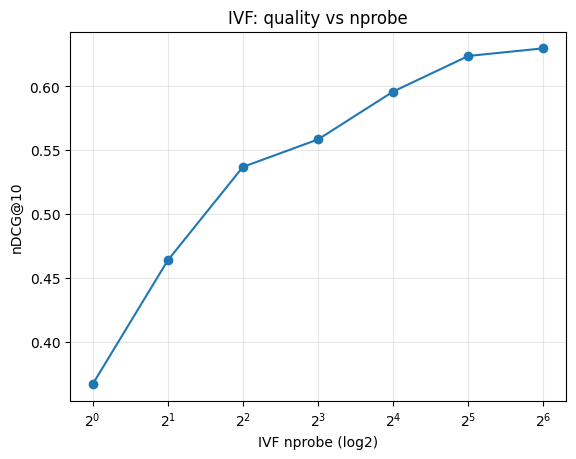

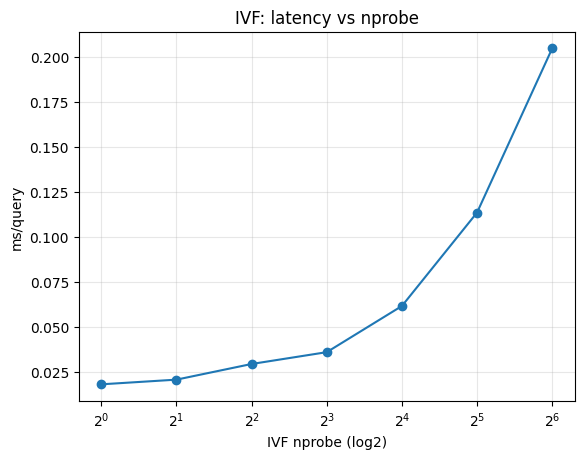

In [13]:
plt.figure()
plt.plot(ivf_df["nprobe"], ivf_df["ndcg@k"], marker="o")
plt.xscale("log", base=2)
plt.xlabel("IVF nprobe (log2)")
plt.ylabel("nDCG@10")
plt.title("IVF: quality vs nprobe")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(ivf_df["nprobe"], ivf_df["ms/query"], marker="o")
plt.xscale("log", base=2)
plt.xlabel("IVF nprobe (log2)")
plt.ylabel("ms/query")
plt.title("IVF: latency vs nprobe")
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# HNSW sweep
ef_vals = [8, 16, 32, 64, 128, 256]
hnsw_rows = []

for ef in ef_vals:
    index_hnsw.hnsw.efSearch = ef
    m = evaluate(index_hnsw, q_emb, query_ids, doc_ids, qrels, k=10)
    hnsw_rows.append({"efSearch": ef, **m})

hnsw_df = pd.DataFrame(hnsw_rows)
hnsw_df[["efSearch","ms/query","recall@k","mrr@k","ndcg@k"]]

,efSearch,ms/query,recall@k,mrr@k,ndcg@k
0,8,0.051843,0.773333,0.584817,0.624815
1,16,0.058464,0.783333,0.596503,0.635773
2,32,0.092842,0.783333,0.596392,0.636312
3,64,0.153997,0.793333,0.604725,0.645082
4,128,0.284631,0.793333,0.604725,0.645082
5,256,0.476421,0.793333,0.604725,0.645082


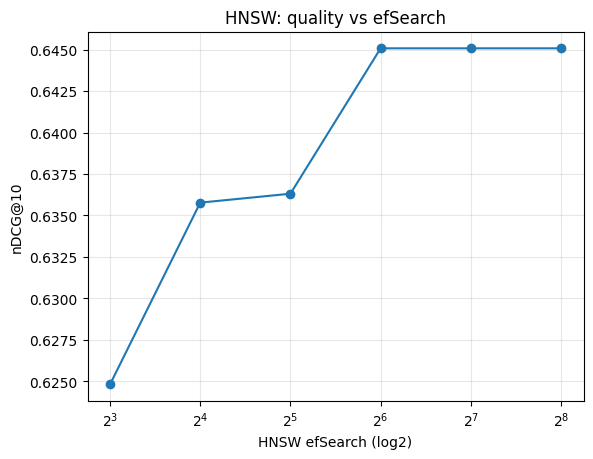

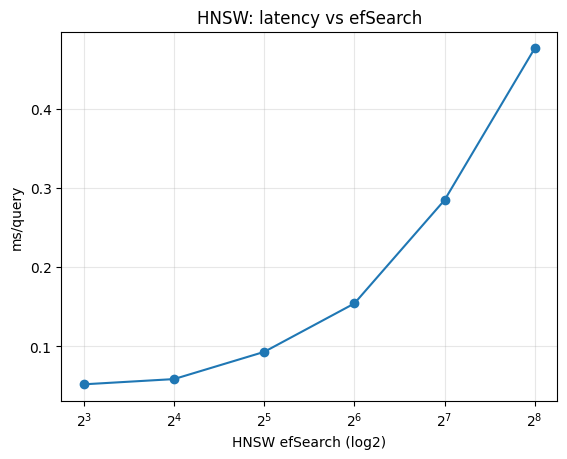

In [15]:
plt.figure()
plt.plot(hnsw_df["efSearch"], hnsw_df["ndcg@k"], marker="o")
plt.xscale("log", base=2)
plt.xlabel("HNSW efSearch (log2)")
plt.ylabel("nDCG@10")
plt.title("HNSW: quality vs efSearch")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(hnsw_df["efSearch"], hnsw_df["ms/query"], marker="o")
plt.xscale("log", base=2)
plt.xlabel("HNSW efSearch (log2)")
plt.ylabel("ms/query")
plt.title("HNSW: latency vs efSearch")
plt.grid(True, alpha=0.3)
plt.show()

# 6. Visualize: speed vs quality scatter (Flat vs IVF points vs HNSW points)

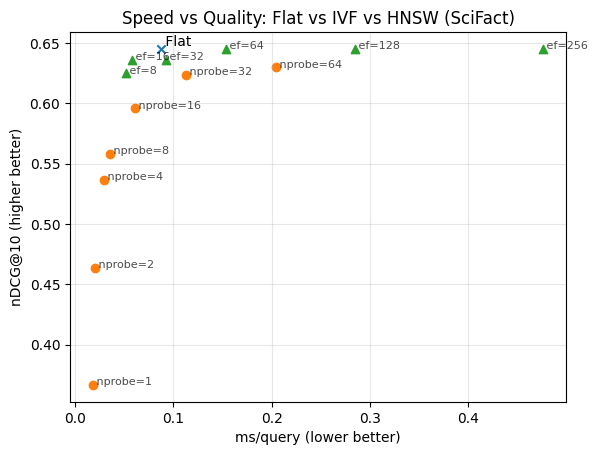

In [16]:
# Restore some default operating points
index_ivf.nprobe = 16
index_hnsw.hnsw.efSearch = 64

flat_m = evaluate(index_flat, q_emb, query_ids, doc_ids, qrels, k=10)

plt.figure()

# Flat
plt.scatter([flat_m["ms/query"]], [flat_m["ndcg@k"]], marker="x")
plt.text(flat_m["ms/query"], flat_m["ndcg@k"], " Flat", va="bottom")

# IVF curve points
plt.scatter(ivf_df["ms/query"], ivf_df["ndcg@k"], marker="o")
for _, r in ivf_df.iterrows():
    plt.text(r["ms/query"], r["ndcg@k"], f" nprobe={int(r['nprobe'])}", fontsize=8, alpha=0.7)

# HNSW curve points
plt.scatter(hnsw_df["ms/query"], hnsw_df["ndcg@k"], marker="^")
for _, r in hnsw_df.iterrows():
    plt.text(r["ms/query"], r["ndcg@k"], f" ef={int(r['efSearch'])}", fontsize=8, alpha=0.7)

plt.xlabel("ms/query (lower better)")
plt.ylabel("nDCG@10 (higher better)")
plt.title("Speed vs Quality: Flat vs IVF vs HNSW (SciFact)")
plt.grid(True, alpha=0.3)
plt.show()

# 7. Inspect retrieval results

In [17]:
def retrieve_table(qid, index, k=10):
    qtext = queries[qid]
    qvec = model.encode([qtext], normalize_embeddings=True, convert_to_numpy=True).astype("float32")
    scores, ids = index.search(qvec, k)

    rel = qrels.get(qid, {})
    rows = []
    for rank, (doc_idx, score) in enumerate(zip(ids[0].tolist(), scores[0].tolist()), start=1):
        doc_id = doc_ids[doc_idx]
        is_rel = int(doc_id in rel)
        title = corpus[doc_id].get("title","").strip()
        snippet = corpus[doc_id]["text"].replace("\n"," ").strip()
        rows.append({
            "rank": rank,
            "score": float(score),
            "relevant": is_rel,
            "doc_id": doc_id,
            "title": title[:90],
            "snippet": (snippet[:200] + ("..." if len(snippet) > 200 else ""))
        })

    print("QID:", qid)
    print("Query:", qtext)
    print("Relevant docs for this query:", len(rel))
    return pd.DataFrame(rows)

# Pick a query that has at least 1 relevant doc
qid = next(q for q in query_ids if len(qrels.get(q, {})) > 0)

display(retrieve_table(qid, index_flat, k=10))
display(retrieve_table(qid, index_ivf, k=10))
display(retrieve_table(qid, index_hnsw, k=10))

QID: 1
Query: 0-dimensional biomaterials show inductive properties.
Relevant docs for this query: 1


,rank,score,relevant,doc_id,title,snippet
0,1,0.354013,0,29638116,Complex Tissue and Disease Modeling using hiPSCs.,Defined genetic models based on human pluripot...
1,2,0.330614,0,4346436,Nonlinear Elasticity in Biological Gels,"Unlike most synthetic materials, biological ma..."
2,3,0.292181,0,3874000,Tissue Mechanics Orchestrate Wnt-Dependent Hum...,Regenerative medicine is predicated on underst...
3,4,0.291616,0,10786948,An efficient nonviral method to generate integ...,The generation of induced pluripotent stem cel...
4,5,0.291556,1,31715818,New opportunities: the use of nanotechnologies...,Nanotechnologies are emerging platforms that c...
5,6,0.290906,0,17388232,Mechanical regulation of cell function with ge...,We report the establishment of a library of mi...
6,7,0.290391,0,86129154,Induced pluripotent stem cell lines derived fr...,Somatic cell nuclear transfer allows trans-act...
7,8,0.275367,0,927561,Emergent structures and dynamics of cell colon...,Cells in tissues can organize into a broad spe...
8,9,0.274130,0,19855358,Direct reprogramming of mouse fibroblasts to c...,Direct reprogramming strategies enable rapid c...
9,10,0.266138,0,1769799,The ins and outs of DNA transfer in bacteria.,Transformation and conjugation permit the pass...


QID: 1
Query: 0-dimensional biomaterials show inductive properties.
Relevant docs for this query: 1


,rank,score,relevant,doc_id,title,snippet
0,1,0.354013,0,29638116,Complex Tissue and Disease Modeling using hiPSCs.,Defined genetic models based on human pluripot...
1,2,0.330614,0,4346436,Nonlinear Elasticity in Biological Gels,"Unlike most synthetic materials, biological ma..."
2,3,0.291616,0,10786948,An efficient nonviral method to generate integ...,The generation of induced pluripotent stem cel...
3,4,0.291556,1,31715818,New opportunities: the use of nanotechnologies...,Nanotechnologies are emerging platforms that c...
4,5,0.290906,0,17388232,Mechanical regulation of cell function with ge...,We report the establishment of a library of mi...
5,6,0.290391,0,86129154,Induced pluripotent stem cell lines derived fr...,Somatic cell nuclear transfer allows trans-act...
6,7,0.275367,0,927561,Emergent structures and dynamics of cell colon...,Cells in tissues can organize into a broad spe...
7,8,0.274130,0,19855358,Direct reprogramming of mouse fibroblasts to c...,Direct reprogramming strategies enable rapid c...
8,9,0.259965,0,6544701,A more efficient method to generate integratio...,"We report a simple method, using p53 suppressi..."
9,10,0.255808,0,1922901,Forces in Tissue Morphogenesis and Patterning,"During development, mechanical forces cause ch..."


QID: 1
Query: 0-dimensional biomaterials show inductive properties.
Relevant docs for this query: 1


,rank,score,relevant,doc_id,title,snippet
0,1,0.354013,0,29638116,Complex Tissue and Disease Modeling using hiPSCs.,Defined genetic models based on human pluripot...
1,2,0.330614,0,4346436,Nonlinear Elasticity in Biological Gels,"Unlike most synthetic materials, biological ma..."
2,3,0.292181,0,3874000,Tissue Mechanics Orchestrate Wnt-Dependent Hum...,Regenerative medicine is predicated on underst...
3,4,0.291616,0,10786948,An efficient nonviral method to generate integ...,The generation of induced pluripotent stem cel...
4,5,0.291556,1,31715818,New opportunities: the use of nanotechnologies...,Nanotechnologies are emerging platforms that c...
5,6,0.290906,0,17388232,Mechanical regulation of cell function with ge...,We report the establishment of a library of mi...
6,7,0.290391,0,86129154,Induced pluripotent stem cell lines derived fr...,Somatic cell nuclear transfer allows trans-act...
7,8,0.275367,0,927561,Emergent structures and dynamics of cell colon...,Cells in tissues can organize into a broad spe...
8,9,0.274130,0,19855358,Direct reprogramming of mouse fibroblasts to c...,Direct reprogramming strategies enable rapid c...
9,10,0.266138,0,1769799,The ins and outs of DNA transfer in bacteria.,Transformation and conjugation permit the pass...


# 8. Save / Load indices

In [18]:
faiss.write_index(index_ivf, "scifact_ivf.index")
faiss.write_index(index_hnsw, "scifact_hnsw.index")

ivf2 = faiss.read_index("scifact_ivf.index")
hnsw2 = faiss.read_index("scifact_hnsw.index")

# restore knobs after load
ivf2.nprobe = 16
hnsw2.hnsw.efSearch = 64

print("Loaded OK.")
print("IVF:", evaluate(ivf2, q_emb, query_ids, doc_ids, qrels, k=10))
print("HNSW:", evaluate(hnsw2, q_emb, query_ids, doc_ids, qrels, k=10))

Loaded OK.
IVF: {'n_valid': 300, 'ms/query': 0.04416942333288413, 'recall@k': 0.7233333333333334, 'mrr@k': 0.5631679894179893, 'ndcg@k': 0.595861673581089}
HNSW: {'n_valid': 300, 'ms/query': 0.17199082999998913, 'recall@k': 0.7933333333333333, 'mrr@k': 0.6047248677248677, 'ndcg@k': 0.6450816521455768}
